# Import libraries and packages

In [21]:
!ls

killings_with_county_dem_and_police_info.csv		 qiskit-tutorials
new_shootings_new_with_county_dem_and_police_info_2.csv  QSVM-baseline.ipynb
qiskit-textbook						 token.txt


In [22]:
# import qiskit library
import qiskit
import cvxpy # dependency needed for QSVM

In [109]:
# for plotting
import matplotlib.pyplot as plt
# for matrix and linear algebra
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from qiskit import IBMQ
IBMQ.save_account(open("token.txt", "r").read())
IBMQ.load_account()
# from qiskit.ml.datasets import ad_hoc_data # preinstalled dataset
# from qiskit import BasicAer # basic simulator
from qiskit.aqua import QuantumInstance # import Quantm Instance to run the experiment
from qiskit.circuit.library import ZZFeatureMap # import quantum feature map
from qiskit.aqua.algorithms import QSVM # import Quantum Support vector Machine model
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name # import several useful unitilies

print("Necessary libraries and packages are imported successfully!")

configrc.store_credentials:WARNING:2021-02-26 05:00:23,038: Credentials already present. Set overwrite=True to overwrite.
/opt/conda/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2021-02-26 05:00:23,261: Credentials are already in use. The existing account in the session will be replaced.


Necessary libraries and packages are imported successfully!


# Setup parameters

In [143]:
# feature dimension
feature_dim = 26
# set the seeds for the random number generator
random_seed = 42
# set shots/ number of iteration (TODO: set this higher when we're ready for the real thing)
shot = 1

In [27]:
rawdat = pd.read_csv('new_shootings_new_with_county_dem_and_police_info_2.csv', low_memory=False)
rawdat.shape
rawdat.head()

,Unnamed: 0,State-county FIPS code,county_state,city_state,City,State,% of killed who carried gun,% of killed who were unarmed,% of killed who were race A,% of killed who were race B,...,calc_percentile_police_spending_ratio,calc_misconduct_settlements_per_10k_population,calc_percentile_misconduct_settlements_per_population,calc_police_shootings_per_arrest,calc_percentile_police_shootings_per_arrest,advocacy_tip,civilian_complaints_source,civilian_complaints_source_link,fips_state_adj,fips_county_adj
0,1,1003.0,Baldwin County AL,Bay Minette AL,Bay Minette,AL,1.0,0.0,0.0,0.0,...,6%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0
1,2,1003.0,Baldwin County AL,Baldwin County AL,Baldwin County,AL,0.0,1.0,0.0,0.0,...,6%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0
2,3,1005.0,Barbour County AL,Eufaula AL,Eufaula,AL,1.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.0
3,4,1009.0,Blount County AL,Brooksville AL,Brooksville,AL,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,9.0
4,5,1015.0,Calhoun County AL,Piedmont AL,Piedmont,AL,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,15.0


In [124]:
rawdat['% of killed who were minority'] = rawdat[["% of killed who were race A",
"% of killed who were race B",
"% of killed who were race H",
"% of killed who were race N",
"% of killed who were race O"]].sum(axis=1)

# Setup data

In [62]:
PREDICTORS = ["use_of_force_complaints_sustained.per.100k", 
              "complaints_in_detention_sustained.per.100k",
              "discrimination_complaints_sustained.per.100k",
              "civilian_complaints_reported.per.100k",
              "calc_low_level_arrests_per_1k_population.per.100k",
              "complaints_in_detention_reported.per.100k",
              "hispanic_as_share_total_arrests"]

In [125]:
PREDICTORS = ["% of killed who carried gun","% of killed who were unarmed",
"% of killed who were minority",
"% of killed who had sign of mental illness","% of killed who were male",
"% of killed who attacked","% of killed whose threat undertermined",
"% of killed who were fleeing","% of killed whose killer had body camera on",
"% of killed age 10 and below","% of killed 30 and below","% of killed 50 and below",
"Estimated percent of people of all ages in poverty 2019",
"Estimated percent of people age 0-17 in poverty 2019",
"Estimated percent of related children age 5-17 in families in poverty 2019",
"Estimate of median household income 2019",
"POP_ESTIMATE_2019",
"Unemployment_rate_2019",
"Percent of adults with less than a high school diploma, 2015-19",
"Percent of adults with a high school diploma only, 2015-19",
"Percent of adults completing some college or associate's degree, 2015-19",
"Percent of adults with a bachelor's degree or higher, 2015-19",
"white_population",
"calc_officers_per_10k_population",
"calc_fines_forfeitures_per_resident",
"calc_police_spending_per_resident"]


len(PREDICTORS)

26

In [126]:
modeldat = rawdat.dropna(subset = ['calc_killed_by_police_per_10k_arrests'] + PREDICTORS,how='any')
modeldat = modeldat.sample(40).reset_index(drop=True)
modeldat.head()

,Unnamed: 0,State-county FIPS code,county_state,city_state,City,State,% of killed who carried gun,% of killed who were unarmed,% of killed who were race A,% of killed who were race B,...,calc_misconduct_settlements_per_10k_population,calc_percentile_misconduct_settlements_per_population,calc_police_shootings_per_arrest,calc_percentile_police_shootings_per_arrest,advocacy_tip,civilian_complaints_source,civilian_complaints_source_link,fips_state_adj,fips_county_adj,% of killed who were minority
0,1042,39113.0,Montgomery County OH,Englewood OH,Englewood,OH,1.000,0.000,0.0,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0,113.0,1.000
1,1302,48157.0,Fort Bend County TX,Rosenberg TX,Rosenberg,TX,1.000,0.000,0.0,0.000,...,NaN,NaN,0.0,100%,NaN,NaN,NaN,48.0,157.0,0.000
2,230,6065.0,Riverside County CA,Moreno Valley CA,Moreno Valley,CA,0.500,0.000,0.0,1.000,...,NaN,NaN,4.3,32%,NaN,NaN,NaN,6.0,65.0,1.000
3,773,26125.0,Oakland County MI,Southfield MI,Southfield,MI,1.000,0.000,0.0,1.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,125.0,1.000
4,1343,48355.0,Nueces County TX,Corpus Christi TX,Corpus Christi,TX,0.625,0.125,0.0,0.125,...,NaN,NaN,1.6,58%,NaN,NaN,NaN,48.0,355.0,0.875


## Convert to a categorical target

In [127]:
modeldat.loc[modeldat['calc_killed_by_police_per_10k_arrests']>=5, 'target'] = 1
modeldat.loc[modeldat['calc_killed_by_police_per_10k_arrests']<5, 'target'] = 0

In [128]:
modeldat = modeldat[['target'] + PREDICTORS]

In [129]:
modeldat['calc_fines_forfeitures_per_resident'] = pd.to_numeric(modeldat['calc_fines_forfeitures_per_resident'].str.replace('$', ''))
modeldat['calc_police_spending_per_resident'] = pd.to_numeric(modeldat['calc_police_spending_per_resident'].str.replace('$', '').str.replace(',', ''))

<ipython-input-129-9dd9f9d1056c>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  modeldat['calc_fines_forfeitures_per_resident'] = pd.to_numeric(modeldat['calc_fines_forfeitures_per_resident'].str.replace('$', ''))
<ipython-input-129-9dd9f9d1056c>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  modeldat['calc_police_spending_per_resident'] = pd.to_numeric(modeldat['calc_police_spending_per_resident'].str.replace('$', '').str.replace(',', ''))


In [130]:
model_train, model_test = train_test_split(modeldat,
                                           test_size=0.33, 
                                           random_state=42)

In [131]:
scaler = MinMaxScaler()
Xtrain_scaled = scaler.fit_transform(model_train[PREDICTORS])
Xtest_scaled = scaler.transform(model_test[PREDICTORS])

In [132]:
train_scaled = pd.DataFrame(Xtrain_scaled)
train_scaled.columns = PREDICTORS
train_scaled['target'] = model_train['target'].reset_index(drop=True)

test_scaled = pd.DataFrame(Xtest_scaled)
test_scaled.columns = PREDICTORS
test_scaled['target'] = model_test['target'].reset_index(drop=True)

,% of killed who carried gun,% of killed who were unarmed,% of killed who were minority,% of killed who had sign of mental illness,% of killed who were male,% of killed who attacked,% of killed whose threat undertermined,% of killed who were fleeing,% of killed whose killer had body camera on,% of killed age 10 and below,...,Unemployment_rate_2019,"Percent of adults with less than a high school diploma, 2015-19","Percent of adults with a high school diploma only, 2015-19","Percent of adults completing some college or associate's degree, 2015-19","Percent of adults with a bachelor's degree or higher, 2015-19",white_population,calc_officers_per_10k_population,calc_fines_forfeitures_per_resident,calc_police_spending_per_resident,target
0,0.500000,0.00,0.000000,0.000000,1.0,0.500,0.0,0.00,0.000,0.0,...,0.085106,0.098637,0.695280,0.587563,0.383842,0.819277,0.360330,0.569211,0.199190,0.0
1,0.000000,0.00,1.000000,0.000000,1.0,1.000,0.0,0.00,0.000,0.0,...,0.936170,0.900673,0.373019,0.605329,0.135809,0.036145,0.000375,0.277061,0.147918,0.0
2,1.000000,0.00,0.000000,0.000000,1.0,1.000,0.0,0.00,0.000,0.0,...,1.106383,0.813538,0.472208,0.459818,0.177562,0.253012,0.029996,0.235513,0.339335,0.0
3,1.000000,0.00,0.000000,0.000000,1.0,1.000,0.0,0.00,0.000,0.0,...,-0.042553,0.039287,0.441459,0.470697,0.632280,0.566265,-0.356955,0.115460,0.260674,0.0
4,0.625000,0.25,0.875000,0.125000,1.0,0.625,0.0,0.25,0.375,0.0,...,0.340426,0.461801,0.522715,0.562987,0.302207,0.204819,0.148481,0.447846,0.428186,0.0
5,1.000000,0.00,1.000000,1.000000,1.0,1.000,0.0,0.00,0.000,0.0,...,0.063830,0.355100,0.107730,0.330868,0.730257,0.144578,0.085864,0.302865,0.778015,1.0
6,0.000000,0.00,0.000000,1.000000,1.0,1.000,0.0,0.00,0.000,0.0,...,0.425532,0.338866,0.951932,0.151177,0.251921,0.915663,0.120360,0.853925,0.334676,0.0
7,0.000000,0.00,0.000000,0.000000,1.0,0.000,0.0,1.00,0.000,0.0,...,0.361702,0.493331,0.439733,0.629280,0.312849,0.204819,0.062242,0.131205,0.498770,0.0
8,1.000000,0.00,0.000000,0.500000,1.0,1.000,0.0,0.50,0.000,0.0,...,0.510638,0.348162,1.142133,0.174890,0.111182,0.289157,0.991751,0.643779,0.831530,0.0
9,0.666667,0.00,0.333333,0.000000,0.0,1.000,0.0,0.00,0.000,0.0,...,0.127660,0.018674,0.031166,0.262702,0.998813,0.481928,0.170604,0.896785,0.357798,0.0


## Pre-processing

## Split data and format for QSVM

In [134]:
pos = np.array(train_scaled.loc[train_scaled['target']==1][PREDICTORS])
neg = np.array(train_scaled.loc[train_scaled['target']==0][PREDICTORS])
train={'pos': pos,'neg': neg}

pos = np.array(test_scaled.loc[test_scaled['target']==1][PREDICTORS])
neg = np.array(test_scaled.loc[test_scaled['target']==0][PREDICTORS])
test={'pos': pos,'neg': neg}
test

{'pos': array([[1.        , 0.        , 1.        , 1.        , 1.        ,
         1.        , 0.        , 0.        , 0.        , 0.        ,
         1.        , 1.        , 0.23611111, 0.30212766, 0.29460581,
         0.60843901, 1.28559857, 0.06382979, 0.35510033, 0.1077299 ,
         0.33086758, 0.73025706, 0.14457831, 0.08586427, 0.30286464,
         0.77801485]]),
 'neg': array([[ 5.00000000e-01,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  1.00000000e+00,  5.00000000e-01,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          1.45833333e-01,  2.42553191e-01,  1.70124481e-01,
          2.91746723e-01,  5.43363314e-02,  8.51063830e-02,
          9.86371875e-02,  6.95279530e-01,  5.87562570e-01,
          3.83841558e-01,  8.19277108e-01,  3.60329959e-01,
          5.69210584e-01,  1.99190089e-01],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00,  1.0000

In [136]:
datapoints = [scaler.transform(modeldat[PREDICTORS]),
              np.array(modeldat['target'])]

In [137]:
datapoints, class_to_label = split_dataset_to_data_and_labels(train)
print(class_to_label)

{'neg': 0, 'pos': 1}


## Setup the backend to run the QSVM

In [144]:
# use the qasm simulator
IBMQ.load_account()
provider=IBMQ.get_provider("ibm-q")
backend=provider.get_backend("ibmq_qasm_simulator")
# backend = BasicAer.get_backend('qasm_simulator')
# define the feature map
"""
Feature Map: 
    a mapping / transformation process which maps the data points from the original plane or space into a much higher dimensional space.
    
    Arg: 
    reps: The number of repeated circuits
    feature_dimension: Number of features.
"""
feature_map = ZZFeatureMap(feature_dim, reps=2)
# define the QSVM model
qsvm = QSVM(feature_map, train, test, None)
# set the random seed for this qsvm
qsvm.random_seed = random_seed
# setup the quantum instance to run the experiment
quantum_instance = QuantumInstance(backend, shots=shot, seed_simulator=random_seed, seed_transpiler=random_seed)

ibmqfactory.load_account:WARNING:2021-02-26 05:08:50,878: Credentials are already in use. The existing account in the session will be replaced.


In [ ]:
# get the result from the above designed experiment on the quantum_instance
result = qsvm.run(quantum_instance)

In [16]:
print(feature_map)

     ┌───┐┌──────────────┐                                           ┌───┐»
q_0: ┤ H ├┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■──┤ H ├»
     ├───┤├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐├───┤»
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├»
     └───┘└──────────────┘└───┘└───────────────────────────────┘└───┘└───┘»
«     ┌──────────────┐                                           
«q_0: ┤ U1(2.0*x[0]) ├──■─────────────────────────────────────■──
«     ├──────────────┤┌─┴─┐┌───────────────────────────────┐┌─┴─┐
«q_1: ┤ U1(2.0*x[1]) ├┤ X ├┤ U1(2.0*(π - x[0])*(π - x[1])) ├┤ X ├
«     └──────────────┘└───┘└───────────────────────────────┘└───┘


## So, this quantum circuit maps our dataset into a much higher dimensional space.





## Check the 'Kernel Matrix' from the 'result'  

**Kernel Matrix**: a sort of distance between points in higher dimension


  Kernel Matrix during the training:



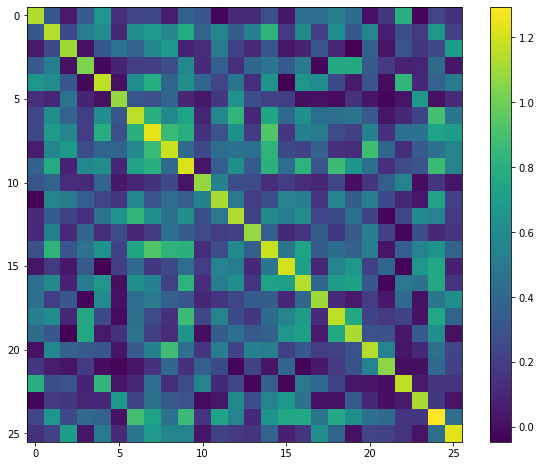

In [17]:
print("\n  Kernel Matrix during the training:\n")
kernel_matrix = result['kernel_matrix_training']
# plot this kernel matrix
plt.figure(figsize=(10, 8))
img = plt.imshow(np.asmatrix(kernel_matrix), interpolation='nearest', origin='upper', cmap='viridis')
plt.colorbar()
plt.show()

## Explanation of this plot  

This plot shows the **kernel matrix** of the training result of the QSVM model/ algorithm. 
First, by applying the quantum feature map, ZZFeatureMap, to remap the dataset into a higher (vector) space. 
Second, calculate the inner product of each possible pair of data points. eg. the inner product of a vector with itself is one. those points at the diagonal are exactly the amplitude of an inner product of each vector with itself,i.e, |<1|1>|^2 = 1.0 ,  |<2|2>|^2 = 1.0,  |<19|19>|^2 = 1.0 , etc. Those dark points with value of zero correspond to the inner product of two orthogonal vectors. 

# Prediction

In [18]:
result.keys()

dict_keys(['kernel_matrix_training', 'svm', 'kernel_matrix_testing', 'testing_accuracy', 'test_success_ratio'])

In [19]:
predicted_labels = qsvm.predict(datapoints[0])
predicted_classes = map_label_to_class_name(predicted_labels, qsvm.label_to_class)
print("Ground truth: {}".format(datapoints[1]))
print("Prediction: {}".format(predicted_labels))

# prediction accuracy
print("testing success ratio: {}".format(result['testing_accuracy']))

Ground truth: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
Prediction: [0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0]
testing success ratio: 0.6428571428571429
